# Parameter Estimation for ODE Systems using Julia

In [1]:
using DifferentialEquations, Plots
using Optimization, SciMLSensitivity, Zygote

In this example, we will reuse a slightly modified version of the homeostatic chemical reaction system from the ODE simulation example. We removed the external input and the sink term of A.

$$
\begin{align}
\dot{A} &= \frac{p_1}{1+C} - k_1A \\
\dot{B} &= k_1A - k_2B \\
\dot{C} &= \frac{k_2B}{1+C} - c_1C  \\
\end{align}
$$

In [2]:
function chemsys!(du, u, p, t)
    A, B, C = u
    p1, k1, k2, c1 = p
    du[1] = ((p1)./(1 .+C)) .- k1.*A
    du[2] = k1.*A .- k2.*B
    du[3] = (k2.*B)./(1 .+C) - c1.*C
end;

# parameters
u0 = [1.8, 0., 0.]
initial_p = [0.1, 0.15, 0.07, 0.12]
tspan = (0., 500.)

# and create an ode problem to solve
problem = ODEProblem(chemsys!, u0, tspan, initial_p);

As a first example, we will try to obtain a steady state of 0.3 for all three molecules after $t = 200$. At first, we have to define a loss function for optimization.

In [25]:
steady_state_target = 0.3
function loss(p) 
    # save the solution at every second until 500 seconds 
    solution = DifferentialEquations.solve(problem,Tsit5(), p=p, saveat=0:500)

    u = Matrix(solution)

    error = sum(abs2, u[:, 201:end].-steady_state_target)
    return error, solution
end

print("The initial loss is $(loss(initial_p)[1])")

The initial loss is 164.15123928955455

We then define an optimization function. For this we first have to specify which algorithm we want to use for automatic differentiation (AD). Often, the AutoZygote option is a good choice. We then use this to define the OptimizationFunction, which takes a function and the AD type as arguments. The function should be a function of the parameters $x$ and the hyperparameters $p$. Because our loss function has no hyperparameters, we specify an anonymous function where the second argument is not used.

In [26]:
adtype = Optimization.AutoZygote()
optf   = Optimization.OptimizationFunction((x,p) -> loss(x), adtype);

We can also define a small callback function to print the loss function value at every step.

In [22]:
callback = function (p, l, pred)
    display(l)
    # Tell Optimization.solve to not halt the optimization. If return true, then
    # optimization stops.
    return false
end

#7 (generic function with 1 method)

Time to optimize! The solver is taken from the OptimizationOptimJL library, where we choose the BFGS solver. We modify the solver a bit, changing the line search algorithm to 3rd-order backtracking, instead of the default Haeger-Zhang, as this results in less gradient calls and a faster optimization. 

In [23]:
using OptimizationOptimJL, LineSearches
opt_problem = Optimization.OptimizationProblem(optf, initial_p, lb = [0.,0.,0.,0.], ub=[0.2,0.2,0.2,0.2]);
sol     = Optimization.solve(opt_problem, BFGS(linesearch=BackTracking(order=3)), callback=callback)
print(sol)

164.15123928955455

8.629194199598384

1.0131401886138012

0.3813425564404528

0.009321128853200146

0.12387145678694533

0.09290463792401875

0.020429375594874667

0.010829094384216812

0.001954100931245641

0.007709480724079571

0.004415355411513583

0.0002271955119267135

0.0001930740035191951

5.8771828912664965e-5

7.089400035534945e-5

6.106457542308194e-5

6.35382912607958e-5

6.316732436761297e-5

6.316685606113578e-5

6.316685530150803e-5

6.316685086231481e-5

6.316684262923817e-5

6.316615720968826e-5

6.316615720968826e-5

6.316615720968826e-5

2.2249432327889983e-5

8.828248556142203e-6

8.735462937086623e-6

8.725784986724903e-6

8.719965151991418e-6

8.690853647004412e-6

8.64738124192892e-6

8.604726181098689e-6

8.604647586552954e-6

8.602871796837401e-6

8.602657448228906e-6

8.602646172777308e-6

8.602645299805888e-6

8.602645274133219e-6

8.602637173366034e-6

8.602637173366034e-6

8.602637173366034e-6

8.601578459313123e-6

8.599835760661486e-6

8.599835696700224e-6

8.597383268342715e-6

8.087088085024018e-6

6.7249844264375815e-6

5.619570435899202e-6

4.308933563362592e-6

3.056314949742922e-6

2.8830871613294944e-6

2.6365452880920225e-6

2.6361886140798645e-6

2.635503291508501e-6

2.635371551737966e-6

2.635371545426732e-6

2.6353715369337796e-6

2.6353715369337796e-6

2.6353715369337796e-6

2.6353711363720665e-6

2.6353704173239964e-6

2.6353683888955123e-6

2.6316796485101586e-6

2.6290306852833228e-6

2.6256413521321117e-6

2.6246231620793206e-6

2.6246113497157685e-6

2.6246113471075287e-6

2.624611012701911e-6

2.624611012701911e-6

2.624611012701911e-6

2.6244602285043515e-6

2.624452107258837e-6

2.6244518261099482e-6

2.6244509979674777e-6

2.6244506911778367e-6

2.6244504020447224e-6

2.6244503765145293e-6

2.624450375379741e-6

2.62445037165092e-6

2.62445037165092e-6

2.62445037165092e-6

2.62445037165092e-6

retcode: Success
u: [0.07127183084160817, 0.18274878039986142, 0.18274790173821195, 0.1405764886384207]
Final objective value:     2.62445037165092e-6


We see that the optimization has succesfully found a solution within our boundaries and we decide to plot the solution.

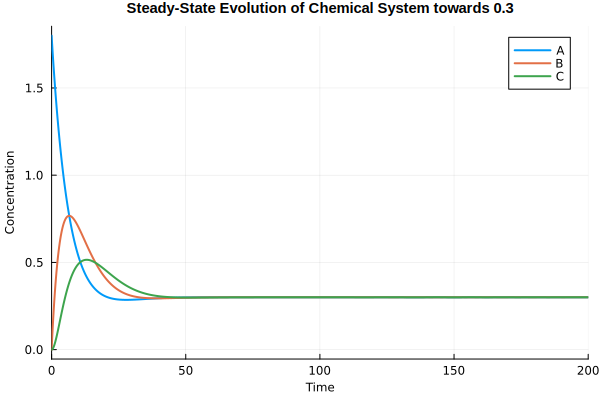

In [41]:
new_system = remake(problem, p = sol.u, tspan=(0.,200.))
new_ode_solution = DifferentialEquations.solve(new_system)
plot(new_ode_solution, linewidth=2, labels=["A" "B" "C"], xlabel="Time", ylabel="Concentration", 
labelfontsize=8, title="Steady-State Evolution of Chemical System towards 0.3", 
titlefontsize = 10, titlefontfamily = "Helvetica Bold")